In [1]:
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import numpy as np

import pandas as pd
import os
import uproot
from scipy import interpolate
from scipy.optimize import curve_fit, fsolve

plt.style.use('physics.mplstyle')

In [2]:
f = uproot.open("../higgsCombineSUEP-m125-darkPho.AsymptoticLimits.mH125.root")
limit = f["limit"].array("limit")
limit

array([  481.61132812, 17133.92988845])

In [3]:
def get_limits(fn):
    f = uproot.open(fn)
    limit = f["limit"].array("limit")
    quant = f["limit"].array("quantileExpected")
    if limit.shape[0] == 1:
        return -1
    else:
        return np.stack([quant,limit])

def get_SUEP_file(Mass=125, decay="darkPho", path="./"):
    fname = os.path.join(
        "../higgsCombineSUEP-m{}-{}.AsymptoticLimits.mH125.root".format(Mass, decay)
    )
    print (fname)
    if os.path.isfile(fname):
        return fname
    else:
        pass

In [4]:
#Mass = 125
#decay = "darkPho"

#limit = get_limits(get_SUEP_file(Mass=Mass, decay=decay))
#print("SUEP m-", Mass, " : ", 
#          np.round(limit[1,2],5), "+/- [",
#          np.round(limit[1,3],5), ",",
#          np.round(limit[1,1],5), "]"
#     )

Mass = 400
decay = "darkPho"

limit = get_limits(get_SUEP_file(Mass=Mass, decay=decay))
print("SUEP m-", Mass, " : ", 
          np.round(limit[1,2],5), "+/- [",
          np.round(limit[1,3],5), ",",
          np.round(limit[1,1],5), "]"
     )

Mass = 750
decay = "darkPho"

limit = get_limits(get_SUEP_file(Mass=Mass, decay=decay))
print("SUEP m-", Mass, " : ", 
          np.round(limit[1,2],5), "+/- [",
          np.round(limit[1,3],5), ",",
          np.round(limit[1,1],5), "]"
     )

Mass = 1000
decay = "darkPho"

limit = get_limits(get_SUEP_file(Mass=Mass, decay=decay))
print("SUEP m-", Mass, " : ", 
          np.round(limit[1,2],5), "+/- [",
          np.round(limit[1,3],5), ",",
          np.round(limit[1,1],5), "]"
     )


../higgsCombineSUEP-m400-darkPho.AsymptoticLimits.mH125.root
SUEP m- 400  :  37.0625 +/- [ 81.77524 , 36.88153 ]
../higgsCombineSUEP-m750-darkPho.AsymptoticLimits.mH125.root
SUEP m- 750  :  30.625 +/- [ 44.15263 , 21.41171 ]
../higgsCombineSUEP-m1000-darkPho.AsymptoticLimits.mH125.root
SUEP m- 1000  :  22.875 +/- [ 32.97931 , 15.54925 ]


In [5]:
def plot_dim_interpolate(decay="darkPho", unblind=True, quadratic=False):
    limits = []
    limitx = []
    for Mass in [125,400,750,1000]:
    #for Mass in [400,1000]:
        try:
            limit = get_limits(get_SUEP_file(Mass=Mass, decay=decay))

            if not isinstance(limit, int) and limit.shape == (2,6):
                limits.append(limit)
                limitx.append(Mass)
        except:
            print(" failed : ", Mass, " : ", decay)
            pass
    limits = np.array(limits)
    limitx = np.array(limitx)
    
    _exp = np.array([l[1][2] for l in limits]) 
    _s1p = np.array([l[1][1] for l in limits]) 
    _s1m = np.array([l[1][3] for l in limits]) 
    _s2p = np.array([l[1][0] for l in limits]) 
    _s2m = np.array([l[1][4] for l in limits])
    _obs = np.array([l[1][5] for l in limits])
    
    print(_exp)
    print(_s2p)
    print(_s2m)
    
    if quadratic:
        exp_limit = interpolate.interp1d(limitx, _exp, bounds_error=False, fill_value="extrapolate", kind="quadratic")
        s1p_limit = interpolate.interp1d(limitx, _s1p, bounds_error=False, fill_value="extrapolate", kind="quadratic")
        s1m_limit = interpolate.interp1d(limitx, _s1m, bounds_error=False, fill_value="extrapolate", kind="quadratic")
        s2p_limit = interpolate.interp1d(limitx, _s2p, bounds_error=False, fill_value="extrapolate", kind="quadratic")
        s2m_limit = interpolate.interp1d(limitx, _s2m, bounds_error=False, fill_value="extrapolate", kind="quadratic")
        obs_limit = interpolate.interp1d(limitx, _obs, bounds_error=False, fill_value="extrapolate", kind="quadratic")
    else:
        exp_limit = interpolate.interp1d(limitx, _exp, bounds_error=False, fill_value="extrapolate", kind="linear")
        s1p_limit = interpolate.interp1d(limitx, _s1p, bounds_error=False, fill_value="extrapolate", kind="linear")
        s1m_limit = interpolate.interp1d(limitx, _s1m, bounds_error=False, fill_value="extrapolate", kind="linear")
        s2p_limit = interpolate.interp1d(limitx, _s2p, bounds_error=False, fill_value="extrapolate", kind="linear")
        s2m_limit = interpolate.interp1d(limitx, _s2m, bounds_error=False, fill_value="extrapolate", kind="linear")
        obs_limit = interpolate.interp1d(limitx, _obs, bounds_error=False, fill_value="extrapolate", kind="linear")
    plt.figure(figsize=(6,6))
    ax = plt.gca()
    
    plt.plot(limitx, _exp,'.', ms=12, color='black')
    xvar = np.linspace(80,1100,1001)
    plt.plot(xvar, exp_limit(xvar), ls="--", ms=12, color='black', label="Median expected")
    
    plt.fill_between(xvar, s2m_limit(xvar), s2p_limit(xvar), color="#FFCC01", lw=0, label="Expected $\pm 2\sigma$")
    plt.fill_between(xvar, s1m_limit(xvar), s1p_limit(xvar), color="#00CC00", lw=0, label="Expected $\pm 1\sigma$")

    #Observed limit
    #plt.plot(limitx, _obs,'.', ms=12, color='black')
    #plt.plot(xvar, obs_limit(xvar), ls="-", ms=12, color='black', label="Median Observed")
    
    #Theoretical cross section
    #plt.plot(thxsec[thxsec.d==dim].Md, 
    #         thxsec[thxsec.d==dim].xsec, #*.101,#* 0.101* 2/3, 
    #         "--", ms=12, color='blue', label="$\sigma_{theory}$ (pb), n = %i" % (dim))
    plt.ylim([0.0, 200])
    plt.xlim([80, 1100 ])
    
    plt.ylabel(r"$\sigma(SUEP)$ (fb)")
    plt.xlabel(r"$M_{SUEP}$ (TeV)")
    plt.legend(loc="upper left", fontsize=14)
    cms = plt.text(
        0., 1., u"CMS $\it{preliminary}$",
        fontsize=16, fontweight='bold',
        horizontalalignment='left', 
        verticalalignment='bottom', 
        transform=ax.transAxes
    )
    lumi = plt.text(
        1., 1., r"%.1f fb$^{-1}$ (13 TeV)" % 60.0,
        fontsize=14, horizontalalignment='right', 
        verticalalignment='bottom', 
        transform=ax.transAxes
    )
    plt.grid(b=True, which='major', color='grey', linestyle='--', alpha=0.3)
    #plt.savefig("plots/SUEP_limits_d_{}.pdf".format(decay))
    #plt.savefig("plots/SUEP_limits_d_{}.png".format(decay))
    plt.show()

decay :  darkPho
../higgsCombineSUEP-m125-darkPho.AsymptoticLimits.mH125.root
../higgsCombineSUEP-m400-darkPho.AsymptoticLimits.mH125.root
../higgsCombineSUEP-m750-darkPho.AsymptoticLimits.mH125.root
../higgsCombineSUEP-m1000-darkPho.AsymptoticLimits.mH125.root
[37.0625 30.625  22.875 ]
[36.33862305 15.79101562 11.08007812]
[115.48307037  60.57977676  45.24938202]


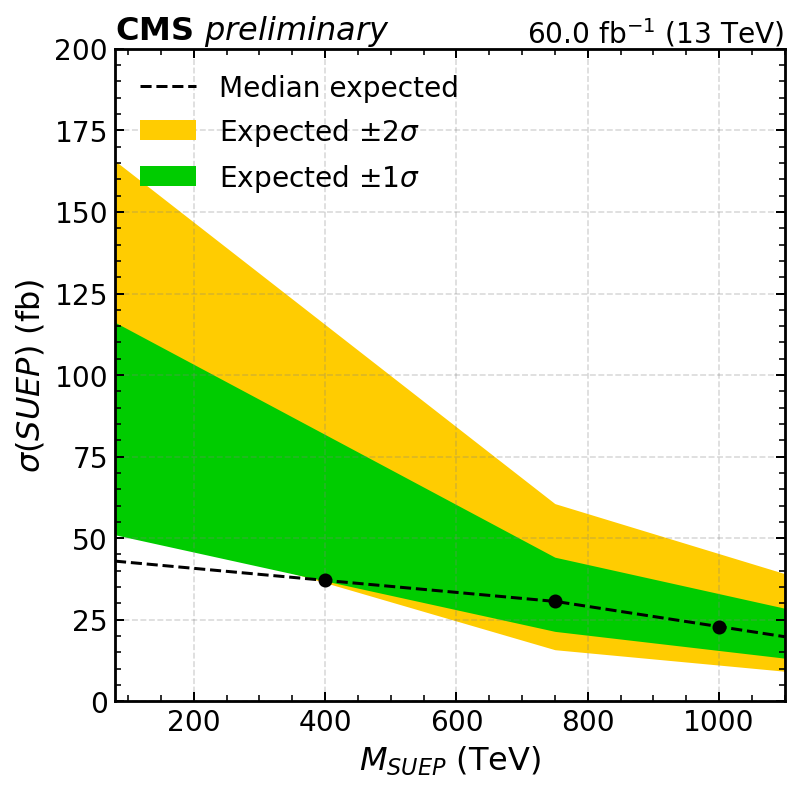

decay :  darkPhoHad
../higgsCombineSUEP-m125-darkPho.AsymptoticLimits.mH125.root
../higgsCombineSUEP-m400-darkPho.AsymptoticLimits.mH125.root
../higgsCombineSUEP-m750-darkPho.AsymptoticLimits.mH125.root
../higgsCombineSUEP-m1000-darkPho.AsymptoticLimits.mH125.root
[37.0625 30.625  22.875 ]
[36.33862305 15.79101562 11.08007812]
[115.48307037  60.57977676  45.24938202]


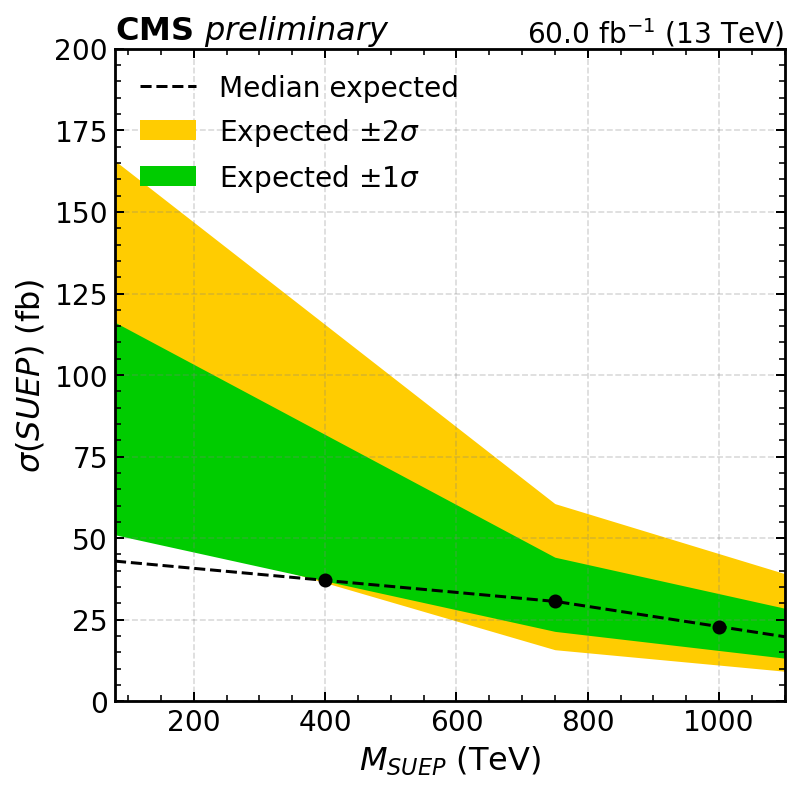

decay :  generic
../higgsCombineSUEP-m125-darkPho.AsymptoticLimits.mH125.root
../higgsCombineSUEP-m400-darkPho.AsymptoticLimits.mH125.root
../higgsCombineSUEP-m750-darkPho.AsymptoticLimits.mH125.root
../higgsCombineSUEP-m1000-darkPho.AsymptoticLimits.mH125.root
[37.0625 30.625  22.875 ]
[36.33862305 15.79101562 11.08007812]
[115.48307037  60.57977676  45.24938202]


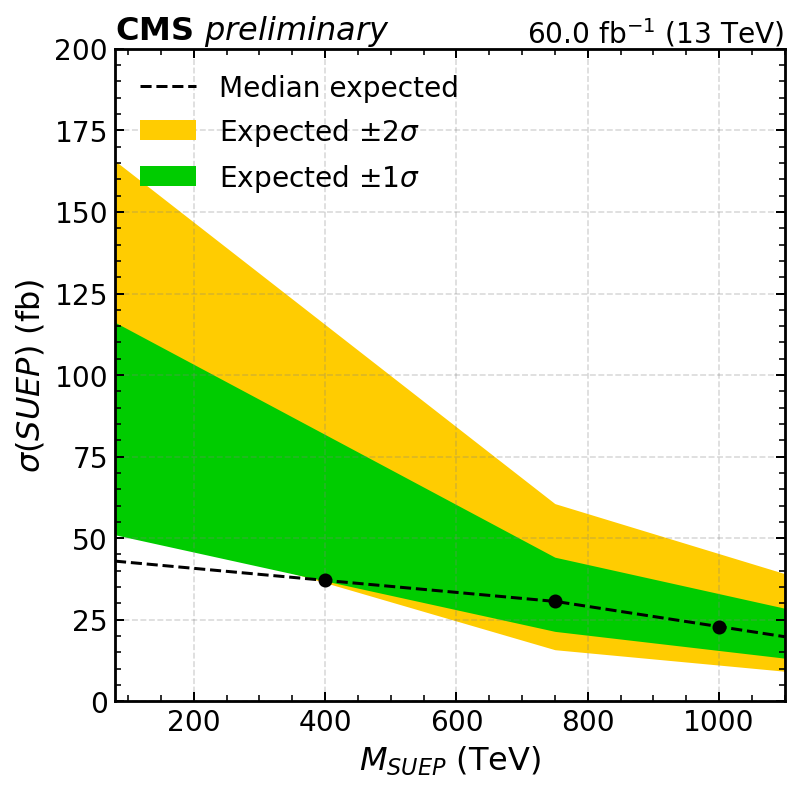

In [106]:
for decay in ["darkPho","darkPhoHad","generic"]:
    print("decay : ", decay)
    plot_dim_interpolate(decay="darkPho", unblind=False, quadratic=False)